In [1]:
from keras.layers import Input, Conv2D, Lambda, merge, Dense, Flatten,MaxPooling2D
from keras.models import Model, Sequential
from keras.callbacks import Callback, ModelCheckpoint, LearningRateScheduler, TerminateOnNaN
from util import EvaluateAccuracy
from keras.regularizers import l2
from keras import backend as K
from keras.optimizers import SGD,Adam
from keras.losses import binary_crossentropy
import numpy.random as rng
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle
%matplotlib inline
def W_init(shape,name=None):
    """Initialize weights as in paper"""
    values = rng.normal(loc=0,scale=1e-2,size=shape)
    return K.variable(values,name=name)
#//TODO: figure out how to initialize layer biases in keras.
def b_init(shape,name=None):
    """Initialize bias as in paper"""
    values=rng.normal(loc=0.5,scale=1e-2,size=shape)
    return K.variable(values,name=name)

input_shape = (105, 105, 1)
left_input = Input(input_shape)
right_input = Input(input_shape)
#build convnet to use in each siamese 'leg'
convnet = Sequential()
convnet.add(Conv2D(64,(10,10),activation='relu',input_shape=input_shape,
                   kernel_initializer=W_init,kernel_regularizer=l2(2e-4)))
convnet.add(MaxPooling2D())
convnet.add(Conv2D(128,(7,7),activation='relu',
                   kernel_regularizer=l2(2e-4),kernel_initializer=W_init,bias_initializer=b_init))
convnet.add(MaxPooling2D())
convnet.add(Conv2D(128,(4,4),activation='relu',kernel_initializer=W_init,kernel_regularizer=l2(2e-4),bias_initializer=b_init))
convnet.add(MaxPooling2D())
convnet.add(Conv2D(256,(4,4),activation='relu',kernel_initializer=W_init,kernel_regularizer=l2(2e-4),bias_initializer=b_init))
convnet.add(Flatten())
convnet.add(Dense(2048,activation="sigmoid",kernel_regularizer=l2(1e-3),kernel_initializer=W_init,bias_initializer=b_init))

#call the convnet Sequential model on each of the input tensors so params will be shared
encoded_l = convnet(left_input)
encoded_r = convnet(right_input)
#layer to merge two encoded inputs with the l1 distance between them
L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
#call this layer on list of two input tensors.
L1_distance = L1_layer([encoded_l, encoded_r])
prediction = Dense(1,activation='sigmoid',bias_initializer=b_init)(L1_distance)
siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)

optimizer = Adam(0.00006)

# Load some weights into the model.
weights_path = 'weights/siamese_net_epoch-136_loss-0.0125_val_loss-0.0918.h5'
siamese_net.load_weights(weights_path, by_name=True)
#//TODO: get layerwise learning rates and momentum annealing scheme described in paperworking
siamese_net.compile(loss="binary_crossentropy",optimizer=optimizer)

siamese_net.count_params()


Using TensorFlow backend.
/home/jerry/anaconda2/envs/tf35/lib/python3.5/site-packages/sklearn/utils/fixes.py:313: FutureWarning: numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  _nan_object_mask = _nan_object_array != _nan_object_array


20073281

## Data 
The data is pickled as an N_classes x n_examples x width x height array, and there is an accompanyng dictionary to specify which indexes belong to which languages.

In [2]:
PATH = "/home/jerry/Projects/keras-oneshot" #CHANGE THIS - path where the pickled data is stored

with open(os.path.join(PATH, "train.pickle"), "rb") as f:
    (X,c) = pickle.load(f)

with open(os.path.join(PATH, "val.pickle"), "rb") as f:
    (Xval,cval) = pickle.load(f)
    
print("training alphabets")
print(c.keys())
print("validation alphabets:")
print(cval.keys())

training alphabets
dict_keys(['vegetation', 'Insignificant_building', 'landmarks', 'complex_nature', 'mono_background'])
validation alphabets:
dict_keys(['vegetation', 'Insignificant_building', 'landmarks', 'complex_nature', 'mono_background'])


In [3]:
class Siamese_Loader:
    """For loading batches and testing tasks to a siamese net"""
    def __init__(self, path, data_subsets = ["train", "val"]):
        self.data = {}
        self.categories = {}
        self.info = {}
        
        for name in data_subsets:
            file_path = os.path.join(path, name + ".pickle")
            print("loading data from {}".format(file_path))
            with open(file_path,"rb") as f:
                (X,c) = pickle.load(f)
                self.data[name] = X
                self.categories[name] = c

    def get_batch(self,batch_size,s="train"):
        """Create batch of n pairs, half same class, half different class"""
        X = self.data[s]
        c = self.categories[s]
        n_classes, n_examples, w, h = X.shape

        #randomly sample several classes in landmark to use in the batch
        categories = rng.choice(range(c['landmarks'][0], c['landmarks'][1]),size=(batch_size,),replace=False)
        #initialize 2 empty arrays for the input image batch
        pairs=[np.zeros((batch_size, h, w,1)) for i in range(2)]
        #initialize vector for the targets, and make one half of it '1's, so 2nd half of batch has same class
        targets=np.zeros((batch_size,))
        targets[:batch_size//3] = 1
        for i in range(batch_size):
            category = categories[i]
            idx_1 = rng.randint(0, n_examples)
            pairs[0][i,:,:,:] = X[category, idx_1].reshape(w, h, 1)
            idx_2 = rng.randint(0, n_examples)
            #pick images of same class for 1st trisection
            if i < batch_size // 3:
                category_2 = category
            #pick another landmark category for the 2nd trisection
            elif (batch_size//3 <= i) and (i < 2*batch_size//3):
                category_2 = rng.choice(range(c['landmarks'][0], c['landmarks'][1]), size=(1,))
                while category_2 == category:
                    category_2 = rng.choice(range(c['landmarks'][0], c['landmarks'][1]), size=(1,))
                
            #pick a non-landmark category for the 3rd trisection
            else: 
                #add a random number to the category modulo n classes to ensure 2nd image has
                # ..different category
                #category_2 = (category + rng.randint(1,n_classes)) % n_classes
                category_2 = rng.choice(n_classes)
                while category_2 in range(c['landmarks'][0], c['landmarks'][1]):
                    category_2 = rng.choice(n_classes)
                
            pairs[1][i,:,:,:] = X[category_2,idx_2].reshape(w, h, 1)
        return pairs, targets
    
    def generate(self, batch_size, s="train"):
        """a generator for batches, so model.fit_generator can be used. """
        while True:
            pairs, targets = self.get_batch(batch_size,s)
            yield (pairs, targets)    

    def make_oneshot_task(self,N,s="val",language=None):
        """Create pairs of test image, support set for testing N way one-shot learning. """
        X = self.data[s]
        c = self.categories[s]
        n_classes, n_examples, w, h = X.shape
        indices = rng.randint(0,n_examples,size=(N,))
        if language is not None:
            low, high = self.categories[s][language]
            if N > high - low:
                raise ValueError("This language ({}) has less than {} letters".format(language, N))
            categories = rng.choice(range(low,high),size=(N,),replace=False)
            
        else:#if no language specified just pick a bunch of random letters
            categories = rng.choice(range(n_classes),size=(N,),replace=False)            
        true_category = rng.choice(range(c['landmarks'][0], c['landmarks'][1]), size=(1,))
        categories[0] = true_category
        ex1, ex2 = rng.choice(n_examples,replace=False,size=(2,))
        test_image = np.asarray([X[true_category,ex1,:,:]]*N).reshape(N, w, h,1)
        support_set = X[categories,indices,:,:]
        support_set[0,:,:] = X[true_category,ex2]
        support_set = support_set.reshape(N, w, h,1)
        targets = np.zeros((N,))
        targets[0] = 1
        targets, test_image, support_set = shuffle(targets, test_image, support_set)
        pairs = [test_image,support_set]

        return pairs, targets
    
    def test_oneshot(self,model,N,k,s="val",verbose=0):
        """Test average N way oneshot learning accuracy of a siamese neural net over k one-shot tasks"""
        n_correct = 0
        if verbose:
            print("Evaluating model on {} random {} way one-shot learning tasks ...".format(k,N))
        for i in range(k):
            inputs, targets = self.make_oneshot_task(N,s)
            probs = model.predict(inputs)
            if np.argmax(probs) == np.argmax(targets):
                n_correct+=1
        percent_correct = (100.0*n_correct / k)
        if verbose:
            print("Got an average of {}% {} way one-shot learning accuracy".format(percent_correct,N))
        return percent_correct
    
    def train(self, model, epochs, verbosity):
        model.fit_generator(self.generate(batch_size),
                            
                             )
    
    
#Instantiate the class
loader = Siamese_Loader(PATH)

loading data from /home/jerry/Projects/keras-oneshot/train.pickle
loading data from /home/jerry/Projects/keras-oneshot/val.pickle


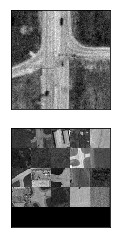

In [4]:

def concat_images(X):
    """Concatenates a bunch of images into a big matrix for plotting purposes."""
    nc,h,w,_ = X.shape
    X = X.reshape(nc,h,w)
    n = np.ceil(np.sqrt(nc)).astype("int8")
    img = np.zeros((n*w,n*h))
    x = 0
    y = 0
    for example in range(nc):
        img[x*w:(x+1)*w,y*h:(y+1)*h] = X[example]
        y += 1
        if y >= n:
            y = 0
            x += 1
    return img


def plot_oneshot_task(pairs):
    """Takes a one-shot task given to a siamese net and  """
    fig,(ax1,ax2) = plt.subplots(2)
    ax1.matshow(pairs[0][0].reshape(105,105),cmap='gray')
    img = concat_images(pairs[1])
    ax1.get_yaxis().set_visible(False)
    ax1.get_xaxis().set_visible(False)
    ax2.matshow(img,cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.show()
#example of a one-shot learning task
pairs, targets = loader.make_oneshot_task(20,"train")
plot_oneshot_task(pairs)


In [5]:
#learning rate schedule
def lr_schedule(epoch):
    if epoch < 30:
        return 0.0001
    elif epoch < 100:
        return 0.00005
    else:
        return 0.00001

#define model callbacks
learning_rate_scheduler = LearningRateScheduler(schedule=lr_schedule,
                                                verbose=1)

N_way = 50 # how many classes for testing one-shot tasks>
n_val = 500 #how mahy one-shot tasks to validate on?

evaluate_accuracy = EvaluateAccuracy(loader, N_way, n_val)

model_checkpoint = ModelCheckpoint(filepath='siamese_net_epoch-{epoch:02d}_loss-{loss:.4f}_val_loss-{val_loss:.4f}.h5',
                                   monitor='val_loss',
                                   verbose=1,
                                   save_best_only=True,
                                   save_weights_only=False,
                                   mode='auto',
                                   period=1)

terminate_on_nan = TerminateOnNaN()



callbacks = [model_checkpoint,
             evaluate_accuracy,
             terminate_on_nan,
             learning_rate_scheduler]
        

In [6]:

# #Training loop
# print("!")
# evaluate_every = 32 # interval for evaluating on one-shot tasks
# loss_every=32 # interval for printing loss (iterations)
# batch_size = 32
# n_iter = 90000
# # N_way = 20 # how many classes for testing one-shot tasks>
# # n_val = 500 #how mahy one-shot tasks to validate on?
# best = -1
# weights_path = os.path.join(PATH, "weights.h5")
# print("training")
# for i in range(1, n_iter):
#     (inputs,targets)=loader.get_batch(batch_size)
#     loss=siamese_net.train_on_batch(inputs,targets)
#     #print("loss in interation %d: %f"%i,loss)
#     if i % evaluate_every == 0:
#         print("evaluating")
#         val_acc = loader.test_oneshot(siamese_net,N_way,n_val,verbose=True)
#         if val_acc >= best:
#             print("saving")
#             siamese_net.save(weights_path)
#             best=val_acc

#     if i % loss_every == 0:
#         print("iteration {}, training loss: {:.2f},".format(i,loss))
        
batchsize = 32
initial_epoch   = 0
final_epoch     = 150
steps_per_epoch = 500

history = siamese_net.fit_generator(generator=loader.generate(batchsize, s="train"),
                                  steps_per_epoch=steps_per_epoch,
                                  epochs=final_epoch,
                                  callbacks=callbacks,
                                  validation_data=loader.generate(batchsize, s="val"),
                                  validation_steps=500,
                                  initial_epoch=initial_epoch)



Epoch 1/150

Epoch 00001: LearningRateScheduler setting learning rate to 0.0001.
500/500 [==============================] - 59s 119ms/step - loss: 0.9851 - val_loss: 0.5588

Epoch 00001: val_loss improved from inf to 0.55885, saving model to siamese_net_epoch-01_loss-0.9851_val_loss-0.5588.h5
evaluating
Evaluating model on 500 random 50 way one-shot learning tasks ...
Got an average of 95.4% 50 way one-shot learning accuracy
Epoch 2/150

Epoch 00002: LearningRateScheduler setting learning rate to 0.0001.
500/500 [==============================] - 57s 115ms/step - loss: 0.4364 - val_loss: 0.3853

Epoch 00002: val_loss improved from 0.55885 to 0.38531, saving model to siamese_net_epoch-02_loss-0.4364_val_loss-0.3853.h5
evaluating
Evaluating model on 500 random 50 way one-shot learning tasks ...
Got an average of 88.2% 50 way one-shot learning accuracy
Epoch 3/150

Epoch 00003: LearningRateScheduler setting learning rate to 0.0001.
500/500 [==============================] - 58s 117ms/step

500/500 [==============================] - 57s 113ms/step - loss: 0.1080 - val_loss: 0.2309

Epoch 00021: val_loss did not improve from 0.21476
evaluating
Evaluating model on 500 random 50 way one-shot learning tasks ...
Got an average of 93.0% 50 way one-shot learning accuracy
Epoch 22/150

Epoch 00022: LearningRateScheduler setting learning rate to 0.0001.
500/500 [==============================] - 57s 113ms/step - loss: 0.1218 - val_loss: 0.2267

Epoch 00022: val_loss did not improve from 0.21476
evaluating
Evaluating model on 500 random 50 way one-shot learning tasks ...
Got an average of 96.2% 50 way one-shot learning accuracy
Epoch 23/150

Epoch 00023: LearningRateScheduler setting learning rate to 0.0001.
500/500 [==============================] - 57s 113ms/step - loss: 0.1186 - val_loss: 0.2414

Epoch 00023: val_loss did not improve from 0.21476
evaluating
Evaluating model on 500 random 50 way one-shot learning tasks ...
Got an average of 95.4% 50 way one-shot learning accuracy

500/500 [==============================] - 57s 113ms/step - loss: 0.0549 - val_loss: 0.1702

Epoch 00043: val_loss did not improve from 0.14512
evaluating
Evaluating model on 500 random 50 way one-shot learning tasks ...
Got an average of 94.4% 50 way one-shot learning accuracy
Epoch 44/150

Epoch 00044: LearningRateScheduler setting learning rate to 5e-05.
500/500 [==============================] - 57s 113ms/step - loss: 0.0520 - val_loss: 0.1931

Epoch 00044: val_loss did not improve from 0.14512
evaluating
Evaluating model on 500 random 50 way one-shot learning tasks ...
Got an average of 95.4% 50 way one-shot learning accuracy
Epoch 45/150

Epoch 00045: LearningRateScheduler setting learning rate to 5e-05.
500/500 [==============================] - 57s 113ms/step - loss: 0.0545 - val_loss: 0.1883

Epoch 00045: val_loss did not improve from 0.14512
evaluating
Evaluating model on 500 random 50 way one-shot learning tasks ...
Got an average of 96.0% 50 way one-shot learning accuracy
E

Got an average of 97.6% 50 way one-shot learning accuracy
Epoch 66/150

Epoch 00066: LearningRateScheduler setting learning rate to 5e-05.
500/500 [==============================] - 56s 113ms/step - loss: 0.0435 - val_loss: 0.1637

Epoch 00066: val_loss did not improve from 0.12632
evaluating
Evaluating model on 500 random 50 way one-shot learning tasks ...
Got an average of 95.4% 50 way one-shot learning accuracy
Epoch 67/150

Epoch 00067: LearningRateScheduler setting learning rate to 5e-05.
500/500 [==============================] - 59s 118ms/step - loss: 0.0401 - val_loss: 0.1749

Epoch 00067: val_loss did not improve from 0.12632
evaluating
Evaluating model on 500 random 50 way one-shot learning tasks ...
Got an average of 97.0% 50 way one-shot learning accuracy
Epoch 68/150

Epoch 00068: LearningRateScheduler setting learning rate to 5e-05.
500/500 [==============================] - 59s 118ms/step - loss: 0.0410 - val_loss: 0.1282

Epoch 00068: val_loss did not improve from 0.126

500/500 [==============================] - 57s 113ms/step - loss: 0.0379 - val_loss: 0.1886

Epoch 00088: val_loss did not improve from 0.10272
evaluating
Evaluating model on 500 random 50 way one-shot learning tasks ...
Got an average of 95.6% 50 way one-shot learning accuracy
Epoch 89/150

Epoch 00089: LearningRateScheduler setting learning rate to 5e-05.
500/500 [==============================] - 56s 113ms/step - loss: 0.0359 - val_loss: 0.1625

Epoch 00089: val_loss did not improve from 0.10272
evaluating
Evaluating model on 500 random 50 way one-shot learning tasks ...
Got an average of 95.4% 50 way one-shot learning accuracy
Epoch 90/150

Epoch 00090: LearningRateScheduler setting learning rate to 5e-05.
500/500 [==============================] - 56s 113ms/step - loss: 0.0364 - val_loss: 0.1630

Epoch 00090: val_loss did not improve from 0.10272
evaluating
Evaluating model on 500 random 50 way one-shot learning tasks ...
Got an average of 95.8% 50 way one-shot learning accuracy
E

500/500 [==============================] - 60s 121ms/step - loss: 0.0223 - val_loss: 0.1686

Epoch 00111: val_loss did not improve from 0.10272
evaluating
Evaluating model on 500 random 50 way one-shot learning tasks ...
Got an average of 96.4% 50 way one-shot learning accuracy
Epoch 112/150

Epoch 00112: LearningRateScheduler setting learning rate to 1e-05.
500/500 [==============================] - 58s 115ms/step - loss: 0.0210 - val_loss: 0.1662

Epoch 00112: val_loss did not improve from 0.10272
evaluating
Evaluating model on 500 random 50 way one-shot learning tasks ...
Got an average of 97.8% 50 way one-shot learning accuracy
Epoch 113/150

Epoch 00113: LearningRateScheduler setting learning rate to 1e-05.
500/500 [==============================] - 58s 115ms/step - loss: 0.0211 - val_loss: 0.2373

Epoch 00113: val_loss did not improve from 0.10272
evaluating
Evaluating model on 500 random 50 way one-shot learning tasks ...
Got an average of 98.0% 50 way one-shot learning accuracy

500/500 [==============================] - 56s 113ms/step - loss: 0.0136 - val_loss: 0.1558

Epoch 00134: val_loss did not improve from 0.10272
evaluating
Evaluating model on 500 random 50 way one-shot learning tasks ...
Got an average of 97.0% 50 way one-shot learning accuracy
Epoch 135/150

Epoch 00135: LearningRateScheduler setting learning rate to 1e-05.
500/500 [==============================] - 57s 114ms/step - loss: 0.0131 - val_loss: 0.1543

Epoch 00135: val_loss did not improve from 0.10272
evaluating
Evaluating model on 500 random 50 way one-shot learning tasks ...
Got an average of 97.8% 50 way one-shot learning accuracy
Epoch 136/150

Epoch 00136: LearningRateScheduler setting learning rate to 1e-05.
500/500 [==============================] - 57s 115ms/step - loss: 0.0125 - val_loss: 0.0918

Epoch 00136: val_loss improved from 0.10272 to 0.09185, saving model to siamese_net_epoch-136_loss-0.0125_val_loss-0.0918.h5
evaluating
Evaluating model on 500 random 50 way one-shot le

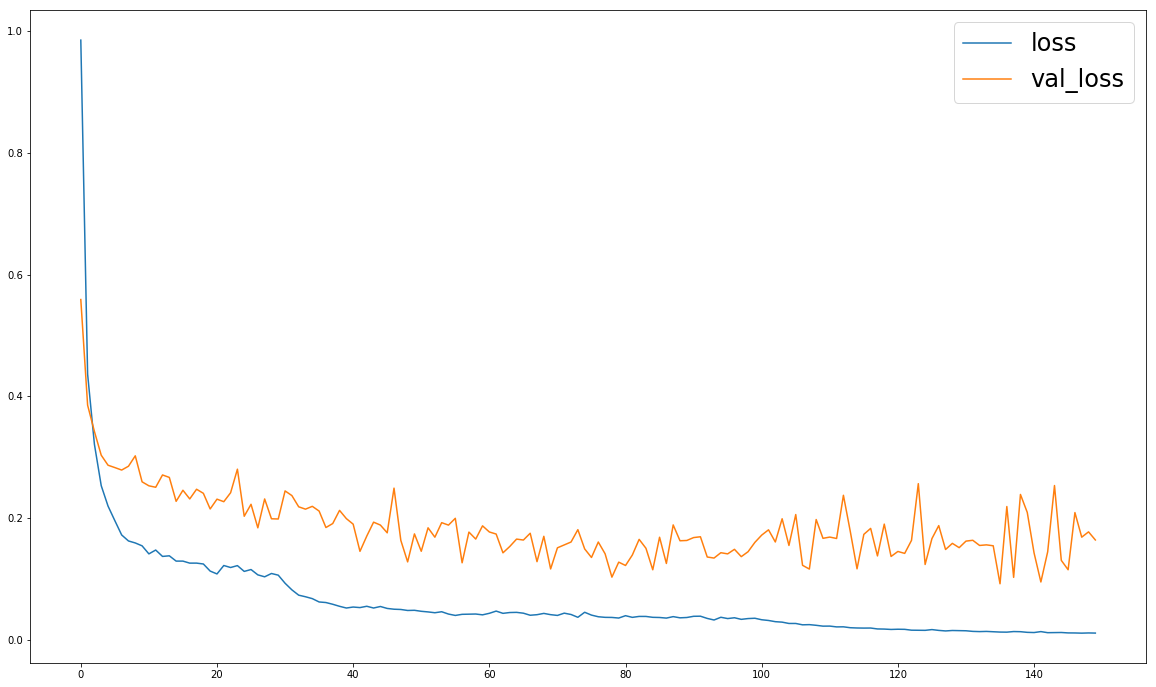

In [7]:
plt.figure(figsize=(20,12))
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend(loc='upper right', prop={'size': 24});

Evaluating model on 450 random 1 way one-shot learning tasks ...
Got an average of 100.0% 1 way one-shot learning accuracy
Evaluating model on 450 random 1 way one-shot learning tasks ...
Got an average of 100.0% 1 way one-shot learning accuracy
Evaluating nearest neighbour on 450 unique 1 way one-shot learning tasks ...
Evaluating model on 450 random 3 way one-shot learning tasks ...
Got an average of 100.0% 3 way one-shot learning accuracy
Evaluating model on 450 random 3 way one-shot learning tasks ...
Got an average of 100.0% 3 way one-shot learning accuracy
Evaluating nearest neighbour on 450 unique 3 way one-shot learning tasks ...
Evaluating model on 450 random 5 way one-shot learning tasks ...
Got an average of 99.77777777777777% 5 way one-shot learning accuracy
Evaluating model on 450 random 5 way one-shot learning tasks ...
Got an average of 99.55555555555556% 5 way one-shot learning accuracy
Evaluating nearest neighbour on 450 unique 5 way one-shot learning tasks ...
Evaluat

Evaluating model on 450 random 49 way one-shot learning tasks ...
Got an average of 98.0% 49 way one-shot learning accuracy
Evaluating model on 450 random 49 way one-shot learning tasks ...
Got an average of 98.66666666666667% 49 way one-shot learning accuracy
Evaluating nearest neighbour on 450 unique 49 way one-shot learning tasks ...
Evaluating model on 450 random 51 way one-shot learning tasks ...
Got an average of 95.77777777777777% 51 way one-shot learning accuracy
Evaluating model on 450 random 51 way one-shot learning tasks ...
Got an average of 99.55555555555556% 51 way one-shot learning accuracy
Evaluating nearest neighbour on 450 unique 51 way one-shot learning tasks ...
Evaluating model on 450 random 53 way one-shot learning tasks ...
Got an average of 96.88888888888889% 53 way one-shot learning accuracy
Evaluating model on 450 random 53 way one-shot learning tasks ...
Got an average of 99.11111111111111% 53 way one-shot learning accuracy
Evaluating nearest neighbour on 450

Got an average of 98.0% 95 way one-shot learning accuracy
Evaluating nearest neighbour on 450 unique 95 way one-shot learning tasks ...
Evaluating model on 450 random 97 way one-shot learning tasks ...
Got an average of 94.44444444444444% 97 way one-shot learning accuracy
Evaluating model on 450 random 97 way one-shot learning tasks ...
Got an average of 97.77777777777777% 97 way one-shot learning accuracy
Evaluating nearest neighbour on 450 unique 97 way one-shot learning tasks ...
Evaluating model on 450 random 99 way one-shot learning tasks ...
Got an average of 96.66666666666667% 99 way one-shot learning accuracy
Evaluating model on 450 random 99 way one-shot learning tasks ...
Got an average of 98.44444444444444% 99 way one-shot learning accuracy
Evaluating nearest neighbour on 450 unique 99 way one-shot learning tasks ...


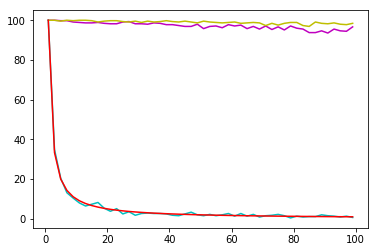

In [10]:
def nearest_neighbour_correct(pairs,targets):
    """returns 1 if nearest neighbour gets the correct answer for a one-shot task
        given by (pairs, targets)"""
    L2_distances = np.zeros_like(targets)
    for i in range(len(targets)):
        L2_distances[i] = np.sum(np.sqrt(pairs[0][i]**2 - pairs[1][i]**2))
    if np.argmin(L2_distances) == np.argmax(targets):
        return 1
    return 0


def test_nn_accuracy(N_ways,n_trials,loader):
    """Returns accuracy of one shot """
    print("Evaluating nearest neighbour on {} unique {} way one-shot learning tasks ...".format(n_trials,N_ways))

    n_right = 0
    
    for i in range(n_trials):
        pairs,targets = loader.make_oneshot_task(N_ways,"val")
        correct = nearest_neighbour_correct(pairs,targets)
        n_right += correct
    return 100.0 * n_right / n_trials


ways = np.arange(1, 100, 2)
resume =  False
val_accs, train_accs,nn_accs = [], [], []
trials = 450
for N in ways:
    val_accs.append(loader.test_oneshot(siamese_net, N,trials, "val", verbose=True))
    train_accs.append(loader.test_oneshot(siamese_net, N,trials, "train", verbose=True))
    nn_accs.append(test_nn_accuracy(N,trials, loader))
    
#plot the accuracy vs num categories for each
plt.plot(ways, val_accs, "m")
plt.plot(ways, train_accs, "y")
plt.plot(ways, nn_accs, "c")

plt.plot(ways,100.0/ways,"r")
plt.show()

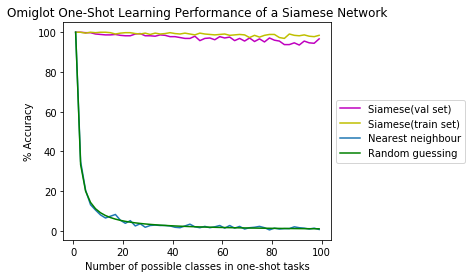

(20, 105, 105, 1)


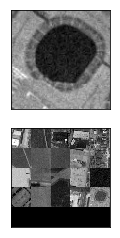

[[  2.81345419e-10]
 [  5.41048362e-09]
 [  1.84424047e-03]
 [  1.86411908e-09]
 [  6.62104128e-07]
 [  1.28630236e-05]
 [  1.49739179e-07]
 [  1.66301902e-07]
 [  3.29712947e-07]
 [  2.74975639e-04]
 [  1.37801922e-03]
 [  4.29957639e-04]
 [  2.10618731e-10]
 [  5.02907227e-09]
 [  7.60567076e-08]
 [  6.15939466e-10]
 [  5.13336254e-08]
 [  5.34935696e-09]
 [  1.40820759e-07]
 [  9.92706358e-01]]


In [11]:
fig,ax = plt.subplots(1)
ax.plot(ways,val_accs,"m",label="Siamese(val set)")
ax.plot(ways,train_accs,"y",label="Siamese(train set)")
plt.plot(ways,nn_accs,label="Nearest neighbour")

ax.plot(ways,100.0/ways,"g",label="Random guessing")
plt.xlabel("Number of possible classes in one-shot tasks")
plt.ylabel("% Accuracy")
plt.title("Omiglot One-Shot Learning Performance of a Siamese Network")
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
inputs,targets = loader.make_oneshot_task(20,"val")
plt.show()

print(inputs[0].shape)
plot_oneshot_task(inputs)
p=siamese_net.predict(inputs)
print(p)

In [ ]:

a=test_nn_accuracy(3,500,loader)
print(a)